In [15]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
import pandas as pd

In [68]:
def mi_schedule(n_iter):
    mis = np.round(np.linspace(0.5, 5.5-1e-9, n_iter)) *2.0#0.1
    return mis.astype(np.float32)

def sigmoid(x):
    return 1/(1. + np.exp(-x))

estimators = [
    'NWJ', 'iMINE', 'iMINE_j', 'SMILE', 'MINE', 'TUBA','InfoNCE', 'JS', 'TNCE', 'alpha'
]
estimates = {}

for estimator in estimators:
    fname = f'gaussian/{estimator}/64/0.pkl'
    estimates[estimator] = pickle.load(open(fname, 'rb'))

# Smooting span for Exponential Moving Average
EMA_SPAN = 200

# Ground truth MI
mi_true = mi_schedule(20000)

# Names specifies the key and ordering for plotting estimators
names = np.sort(list(estimators))
clean_names = {k: k for k in estimators}
clean_names['SMILE'] = r'SMILE ($\tau=100$)'
clean_names['alpha'] = r'$I_{\alpha}$ ($\alpha=0.01$)'
clean_names['iMINE'] = r'iMINE (C=0, $\lambda=1$)'
clean_names['iMINE_j'] = 'iMINE-J (C=0, $\\lambda=1$)'


nrows = min(2, len(estimates))
ncols = int(np.ceil(len(estimates) / float(nrows)))
nrows, ncols

(2, 5)

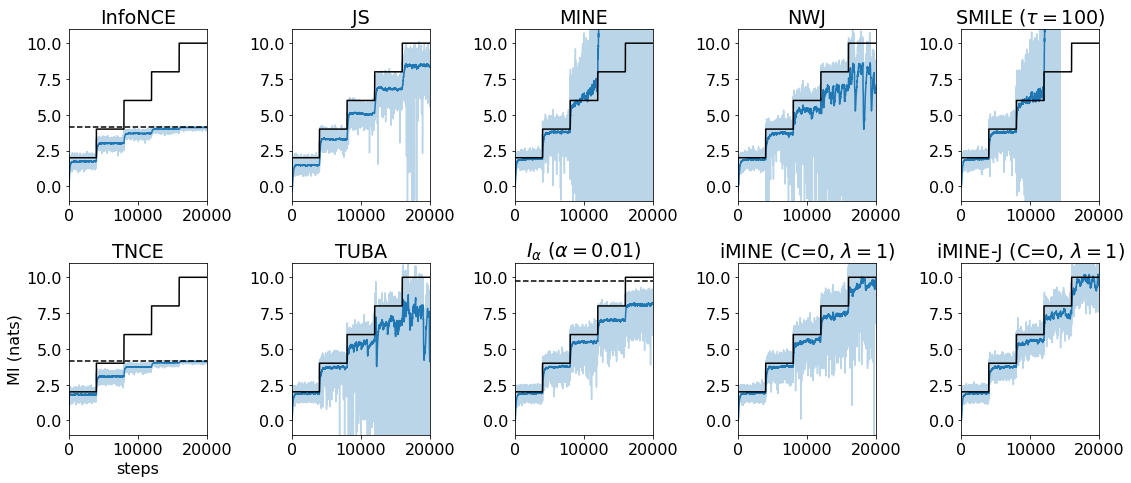

In [77]:
import matplotlib
#matplotlib.rc('font', size=16)

fig, axs = plt.subplots(nrows, ncols, figsize=(16, 7)) 
if len(estimates) == 1:
    axs = [axs]
axs = np.ravel(axs)

for i, name in enumerate(names):
    plt.sca(axs[i])
    plt.title(clean_names[names[i]])
    # Plot estimated MI and smoothed MI
    mis = estimates[name]  
    mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
    p1 = plt.plot(mis, alpha=0.3)[0]
    plt.plot(mis_smooth, c=p1.get_color())
    # Plot true MI and line for log(batch size)
    plt.plot(mi_true, color='k', label='True MI')
    if 'alpha' in name or 'NCE' in name:
        # Add theoretical upper bound lines
        if 'alpha' in name:
            log_alpha = -np.log( 1+ np.exp(4.595))
        else:
            log_alpha = 1.
        plt.axhline(1 + np.log(64) - log_alpha, c='k', linestyle='--', label=r'1 + log(K/$\alpha$)' )
    plt.ylim(-1, mi_true.max()+1)
    plt.xlim(0, 20000)
    if i == len(estimates) - ncols:
        plt.xlabel('steps')
        plt.ylabel('MI (nats)')
    plt.tight_layout()
#plt.legend(loc='best', fontsize=8, framealpha=0.0)
plt.gcf().tight_layout()
#plt.savefig('test1.png')
plt.show()

<IPython.core.display.Javascript object>


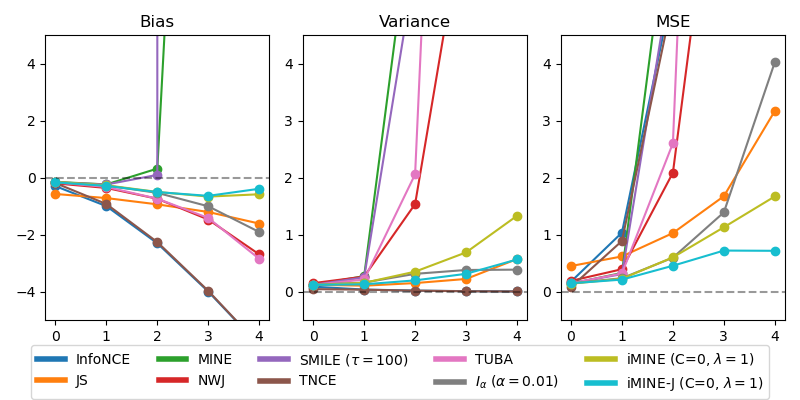


\multicolumn{1}{c|}{\multirow{10}{*}{ NAME }} & InfoNCE & -0.30 & -1.00 & -2.31 & -4.00 & -5.89 \\
\multicolumn{1}{c|}{} & JS & -0.57 & -0.72 & -0.94 & -1.21 & -1.61 \\
\multicolumn{1}{c|}{} & MINE & -0.15 & -0.24 & 0.32 & 33.81 &  \\
\multicolumn{1}{c|}{} & NWJ & -0.20 & -0.36 & -0.74 & -1.47 & -2.70 \\
\multicolumn{1}{c|}{} & SMILE ($\tau=100$) & -0.16 & -0.24 & 0.10 &  &  \\
\multicolumn{1}{c|}{} & TNCE & -0.19 & -0.93 & -2.26 & -3.98 & -5.88 \\
\multicolumn{1}{c|}{} & TUBA & -0.17 & -0.33 & -0.74 & -1.42 & -2.85 \\
\multicolumn{1}{c|}{} & $I_{\alpha}$ ($\alpha=0.01$) & -0.16 & -0.28 & -0.53 & -1.01 & -1.91 \\
\multicolumn{1}{c|}{} & iMINE (C=0, $\lambda=1$) & -0.15 & -0.27 & -0.50 & -0.66 & -0.58 \\
\multicolumn{1}{c|}{} & iMINE-J (C=0, $\lambda=1$) & -0.16 & -0.29 & -0.51 & -0.64 & -0.39 \\

\multicolumn{1}{c|}{\multirow{10}{*}{ NAME }} & InfoNCE & 0.09 & 0.03 & 0.02 & 0.01 & 0.00 \\
\multicolumn{1}{c|}{} & JS & 0.12 & 0.10 & 0.15 & 0.22 & 0.57 \\
\multicolumn{1}{c|}{} & MINE & 0

In [152]:
%matplotlib notebook
import matplotlib
matplotlib.rc('font', size=10)

from matplotlib.lines import Line2D

def bias(arr, true_mi):
    return np.mean(arr) - true_mi

def variance(arr, true_mi):
    return np.var(arr)

def mse(arr, true_mi):
    return np.mean(np.square(arr-true_mi))


fig, axs = plt.subplots(1, 3, figsize=(8, 4)) 
axs = np.ravel(axs)

for i, f in enumerate([bias, variance, mse]):
    plt.sca(axs[i])
    print('')
    for name_index, name in enumerate(names):
        mis = estimates[name]
        points = []
        for j in range(5):
            true_mi = (j+1)*2
            points.append(f(mis[j*4000:(j+1)*4000], true_mi))
        axs[i].plot(list(range(5)), points, 'o-', label=name, c=f'C{name_index}')
        
        if name_index == 0:
            print(r'\multicolumn{1}{c|}{\multirow{10}{*}{ NAME }}', end='')
        else:
            print(r'\multicolumn{1}{c|}{}', end='')
        print(f' & {clean_names[name]} & ' + ' & '.join(['%.2f'%f if f < 100 else '' for f in points]) + r' \\',)

    axs[i].axhline(0, linestyle='--', color='black', alpha=0.4)
    if i == 0:
        axs[i].set_ylim((-5, 5))
        axs[i].set_title('Bias')        
    elif i == 1:
        axs[i].set_ylim((-0.5, 4.5))
        axs[i].set_title('Variance')
    else:
        axs[i].set_ylim((-0.5, 4.5))
        axs[i].set_title('MSE')

lines = [
    Line2D([0], [0], color=f'C{i}', lw=4)
    for i, name in enumerate(names)
]
        
plt.gcf().tight_layout()
plt.gcf().legend(lines, [clean_names[n] for n in names], ncol=5, loc='center', bbox_to_anchor=(0.5, 0.07))
plt.gcf().subplots_adjust(bottom=0.2)
plt.show()